In [1]:
from optim_relu_max_linear import OptimReluMaxLinear
import triton
import torch

In [2]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["B", "L", "D", "V"],  # Argument names to use as an x-axis for the plot
        x_vals=[64 * i for i in range(1, 10)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["torch", "triton"],  # Label name for the lines
        line_names= ["torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={},
    ))


In [3]:
@triton.testing.perf_report(configs)
def benchmark(B, L, D, V, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = torch.randn(V, requires_grad=True, dtype=torch.float64, device='cuda')
    list_lengths = torch.randint(0, L, [B])
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
        
    mask_inf = torch.where(mask == 1, 0, -torch.inf)
    relu = torch.nn.ReLU()
    
    torch_calculation = relu(torch.max((x @ w) + b.reshape(1, 1, *b.shape) + mask_inf.reshape(*mask_inf.shape, 1), dim=1)[0])
    triton_calculation = OptimReluMaxLinear.apply(x, w, b, mask)[0]
        
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_calculation.sum().backward(retain_graph=True), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_calculation.sum().backward(retain_graph=True) , quantiles=quantiles)
    gbps = lambda ms: B * L * D * V / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

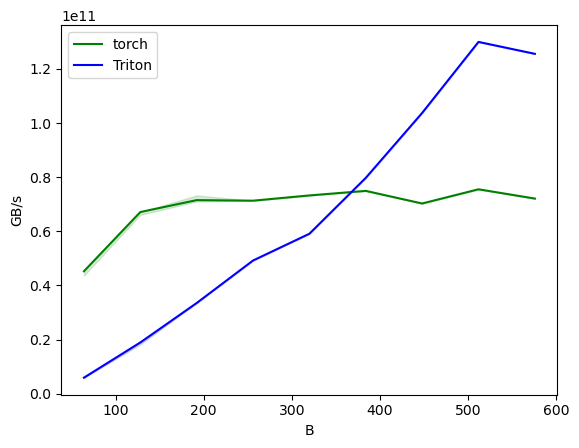

relu_max_backward_performance:
       B      L      D      V         torch        Triton
0   64.0   64.0   64.0   64.0  4.525967e+10  5.953488e+09
1  128.0  128.0  128.0  128.0  6.711477e+10  1.895131e+10
2  192.0  192.0  192.0  192.0  7.151500e+10  3.351309e+10
3  256.0  256.0  256.0  256.0  7.130623e+10  4.921390e+10
4  320.0  320.0  320.0  320.0  7.324689e+10  5.910085e+10
5  384.0  384.0  384.0  384.0  7.492815e+10  7.973019e+10
6  448.0  448.0  448.0  448.0  7.026899e+10  1.037017e+11
7  512.0  512.0  512.0  512.0  7.551360e+10  1.299358e+11
8  576.0  576.0  576.0  576.0  7.208952e+10  1.255361e+11


In [4]:
benchmark.run(show_plots=True, print_data=True)